# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image`: None
    
- `Image Size`: 256x256
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (4,4) 
    
- 'No Finding`: Deleting No Finding in Label_unique 2 

- `Label Smoothing`: 0.2
    
- `Loss`: CategorialCrossEntropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip(p=0.5)
    
- `Strong Augment`: X
  
- `BackBone Model`: TF ResNet18
    
- `Freezing Layer`: 10% Layers
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [1]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import Model, losses, optimizers, layers
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

import warnings 
import albumentations as albu
warnings.filterwarnings('ignore')

## GPU Settings
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None

tensorflow version:  2.16.1
Using 2 GPUs


In [2]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [4]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [5]:
RAPID_CXR = True

In [6]:
if RAPID_CXR:
    df = pd.read_csv('/kaggle/input/rapid-cxr-dataset/metadata.csv')
    tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*', '*'))}    
    
    df['path'] = df['Image Index'].map(tmp)

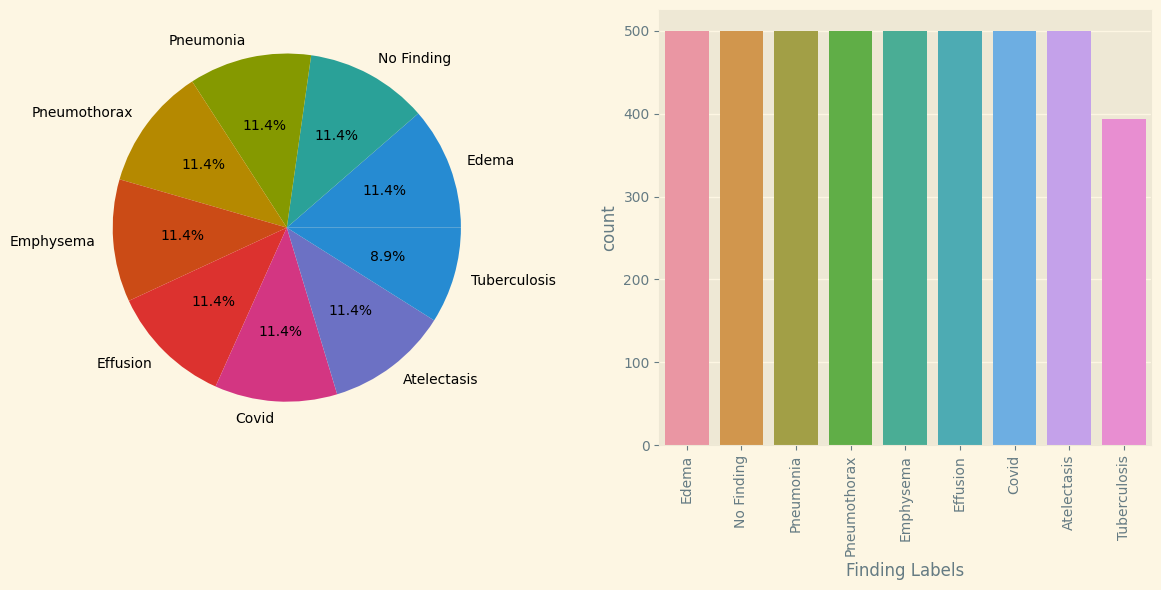

In [7]:
label_counts = df['Finding Labels'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**Hierachy Multi Label**

![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F16438831%2F5f06f322b79a079a0e8a51699e6deb20%2Fdataset.JPG?generation=1725424573083570&alt=media)

In [8]:
def parent_level(row):
    if row in ['No Finding']:
        return 'Parent_No Finding'
    elif row in ['Covid','Tuberculosis','Edema','Atelectasis','Pneumonia']:
        return 'Parent_Lung Opacity'
    elif row in ['Pneumothorax','Effusion']:
        return 'Parent_Pleural'
    else:
        return 'Parent_Emphysema'

In [9]:
df['Parent Labels'] = df['Finding Labels'].apply(lambda x: parent_level(x))

**Train & Test Split**

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

`TARGET`: Parent Label

`TARGET2`: Child Label(Lung Opacity)

`TARGET3`: Child Label(Pleural)

`TARGET4`: Totat Label

In [11]:
for col in df['Parent Labels'].unique():
    df_test[col] = np.where(df_test['Parent Labels'].str.contains(col), 1.0, 0.0).astype('float32')
    df_train[col] = np.where(df_train['Parent Labels'].str.contains(col), 1.0, 0.0).astype('float32')
TARGET = df_train.columns[-4:].tolist()
print('Parent Label is', TARGET)

Parent Label is ['Parent_Lung Opacity', 'Parent_No Finding', 'Parent_Pleural', 'Parent_Emphysema']


In [12]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')

In [13]:
TARGET2 = ['Covid','Tuberculosis','Edema','Atelectasis','Pneumonia']
print('Child Label is', TARGET2)
TARGET3 = ['Pneumothorax','Effusion']
print('Child Label is', TARGET3)
TARGET4 = ['Covid', 'Tuberculosis', 'Edema','Atelectasis','Pneumonia','No Finding', 'Pneumothorax', 'Effusion','Emphysema']
print('Total Label is', TARGET4)

Child Label is ['Covid', 'Tuberculosis', 'Edema', 'Atelectasis', 'Pneumonia']
Child Label is ['Pneumothorax', 'Effusion']
Total Label is ['Covid', 'Tuberculosis', 'Edema', 'Atelectasis', 'Pneumonia', 'No Finding', 'Pneumothorax', 'Effusion', 'Emphysema']


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build DataGenerator</b></div>

In [14]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        
    def __len__(self):
        
        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y
    
    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
        
    def __data_generation(self, indexes):
        
        X = np.zeros((len(indexes),256,256,3), dtype='float32') 
        if self.data['Finding Labels'].nunique() == 9:
            y = np.zeros((len(indexes),len(TARGET)), dtype='float32')
        elif self.data['Finding Labels'].nunique() == 5:
            y = np.zeros((len(indexes),len(TARGET2)), dtype='float32')
        elif self.data['Finding Labels'].nunique() == 2:
            y = np.zeros((len(indexes),len(TARGET3)), dtype='float32')
            
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((256,256), Image.Resampling.LANCZOS) # DownSampling
            img = np.array(img) # PIL Object -> np.array(uint8)
            img = self.clahe.apply(img)
            img = np.tile(img[...,np.newaxis], (1,1,3))
            
            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)
            
            X[j,:,:] = img
            if self.data['Finding Labels'].nunique() == 9:
                y[j,] = row[TARGET]
            elif self.data['Finding Labels'].nunique() == 5:
                y[j,] = row[TARGET2]
            elif self.data['Finding Labels'].nunique() == 2:
                y[j,] = row[TARGET3]
            
        return X,y
    
    def __augment1(self, img_batch):
        
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            albu.Rotate(limit=5, p=0.5),
        ])
        
        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img
            
        return img_batch
    
    
    def __augment2(self, img_batch, n_needles=1, dark_needles=False, p=0.5, needle_folder='../input/xray-needle-augmentation'):
        for i in range(img_batch.shape[0]):
            image = img_batch[i,]
            aug_prob = random.random()
            if aug_prob <= p:
                height, width, _ = image.shape  # target image width and height
                needle_images = [im for im in os.listdir(needle_folder)]

                for _ in range(n_needles):  # Ensure correct number of needles
                    needle = cv2.cvtColor(cv2.imread(os.path.join(needle_folder, random.choice(needle_images))), cv2.COLOR_BGR2RGB)
                    needle = cv2.flip(needle, random.choice([-1, 0, 1]))
                    needle = cv2.rotate(needle, random.choice([0, 1, 2]))

                    # Resize needle to match ROI dimensions
                    needle_resized = cv2.resize(needle, (width, height), interpolation=cv2.INTER_AREA)

                    # Creating a mask and inverse mask
                    img2gray = cv2.cvtColor(needle_resized, cv2.COLOR_RGB2GRAY)
                    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
                    mask_inv = cv2.bitwise_not(mask)


                    img_bg = cv2.bitwise_and(image, image, mask=mask_inv)
                    img_bg = img_bg.astype(np.uint8)
                    if dark_needles:
                        needle_fg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
                    else:
                        needle_fg = cv2.bitwise_and(needle_resized, needle_resized, mask=mask)

                    # Put needle in ROI and modify the target image
                    dst = cv2.add(img_bg, needle_fg)

                    image = dst
                    
            img_batch[i,] = image.astype(np.float32)

        return img_batch

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build ResNet Model</b></div>

**Install ResNet**

In [15]:
!pip install -q git+https://github.com/qubvel/classification_models.git

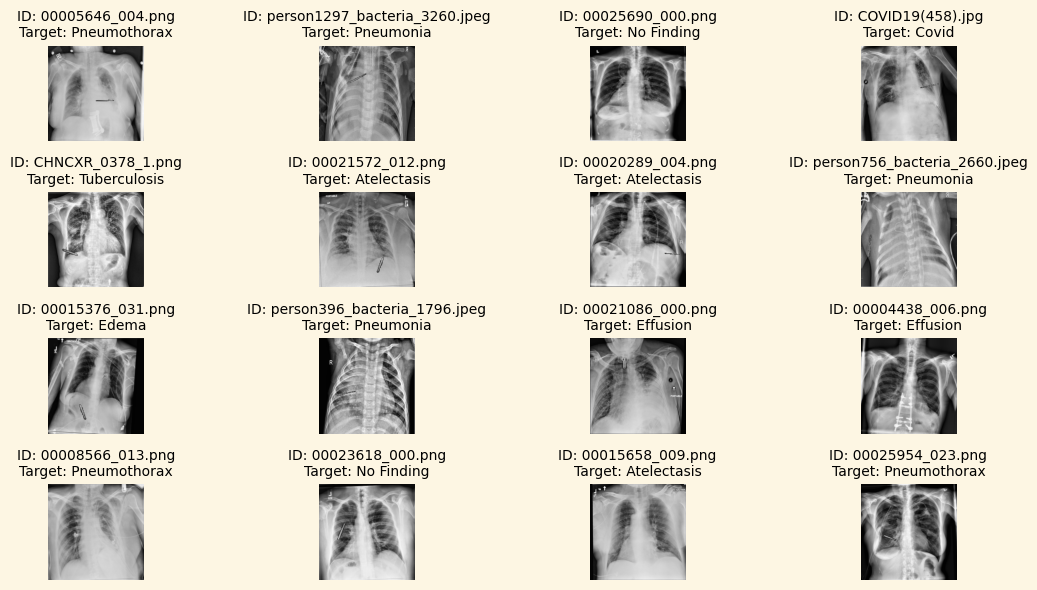

In [16]:
from classification_models.tfkeras import Classifiers

resnet18, preprocess_input = Classifiers.get('resnet18')

ROWS = 4; COLS = 4; BATCHES = 1

gen = DataGenerator(df_train, batch_size=16, shuffle=False, augment1=True, augment2=True, preprocess=preprocess_input)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

#### Macro F1_Score

In [17]:
def f1(y_true, y_pred):
    # Calculate the F1 score for each class
    f1_scores = []
    num_classes = K.int_shape(y_pred)[-1]  # (batch_size, output_dims = num_classes)
    
    # Get the true and predicted class indices
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1) # For Label Smoothing(in CCE)

    for i in range(num_classes):
        true_positives = K.sum(K.cast(tf.logical_and(K.equal(y_true, i), K.equal(y_pred, i)), dtype=tf.float32))
        possible_positives = K.sum(K.cast(K.equal(y_true, i), dtype=tf.float32))
        predicted_positives = K.sum(K.cast(K.equal(y_pred, i), dtype=tf.float32))

        recall = true_positives / (possible_positives + K.epsilon())
        precision = true_positives / (predicted_positives + K.epsilon())
        
        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        f1_scores.append(f1_score)
    
    # Calculate the macro-average F1 score
    macro_f1_score = K.mean(tf.stack(f1_scores))
    return macro_f1_score

def f1_loss(y_true, y_pred):
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    
    macro_f1_score = K.mean(f1)
    return 1 - macro_f1_score


**ReduceLROnPleateau in Callbacks**

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

EPOCHS = 10

lr = ReduceLROnPlateau(monitor = 'val_f1', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

### Parent Model

In [19]:
def parent_model(): 
    inp = tf.keras.layers.Input(shape=(256,256,3)) 
    res_model = resnet18(include_top=False, weights='imagenet', input_shape=(256,256,3)) 
    res_model._name = 'resnet18' 

    ## Freezing Layer(10% Layer)
    for layer in res_model.layers[:len(res_model.layers)//10]:
        layer.trainable = False

    x = res_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(len(TARGET), activation='softmax', dtype='float32')(x)

    # Compile
    model = tf.keras.Model(inputs=inp, outputs=x)

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy', f1])

    return model

### Child Model: Lung Opacity

In [20]:
def opacity_model(): 
    inp = tf.keras.layers.Input(shape=(256,256,3)) 
    res_model = resnet18(include_top=False, weights='imagenet', input_shape=(256,256,3)) 
    res_model._name = 'resnet18' 

    ## Freezing Layer(10% Layer)
    for layer in res_model.layers[:len(res_model.layers)//10]:
        layer.trainable = False

    x = res_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(len(TARGET2), activation='softmax', dtype='float32')(x)

    # Compile
    model = tf.keras.Model(inputs=inp, outputs=x)

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy', f1])

    return model

### Child Model: Pleural

In [21]:
def pleural_model(): 
    inp = tf.keras.layers.Input(shape=(256,256,3)) 
    res_model = resnet18(include_top=False, weights='imagenet', input_shape=(256,256,3)) 
    res_model._name = 'resnet18' 

    ## Freezing Layer(10% Layer)
    for layer in res_model.layers[:len(res_model.layers)//10]:
        layer.trainable = False

    x = res_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(len(TARGET3), activation='sigmoid', dtype='float32')(x)

    # Compile
    model = tf.keras.Model(inputs=inp, outputs=x)

    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy', f1])

    return model

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>6. Train Lung Opacity Model</b></div>

In [22]:
tmp = df_train[df_train['Finding Labels'].isin(['Covid','Tuberculosis','Edema','Atelectasis','Pneumonia'])]
tmp = tmp.reset_index(drop=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(tmp, tmp['Finding Labels'])):
    tmp.loc[valid_index, 'Fold'] = i

#########################
### Fold 1
### train size 1495, valid size 374
#########################
44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.5673 - f1: 0.4581 - loss: 1.5103 - val_accuracy: 0.4225 - val_f1: 0.2609 - val_loss: 4.8837 - learning_rate: 0.0010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 99s 993ms/step - accuracy: 0.7132 - f1: 0.5991 - loss: 0.9499 - val_accuracy: 0.3583 - val_f1: 0.2730 - val_loss: 3.3803 - learning_rate: 0.0010
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 98s 989ms/step - accuracy: 0.7292 - f1: 0.6078 - loss: 0.9134 - val_accuracy: 0.6043 - val_f1: 0.4902 - val_loss: 1.9914 - learning_rate: 0.0010
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 98s 994ms/step - accuracy: 0.7970 - f1: 0.6555 - loss: 0.8239 - val_accuracy: 0.7326 - val_f1: 0.6773 - val_loss: 0.9372 - learning_rate: 0.0010
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.8036 - f1: 0.6846 - loss: 0.8399
Epoch 5: ReduceLROnPl

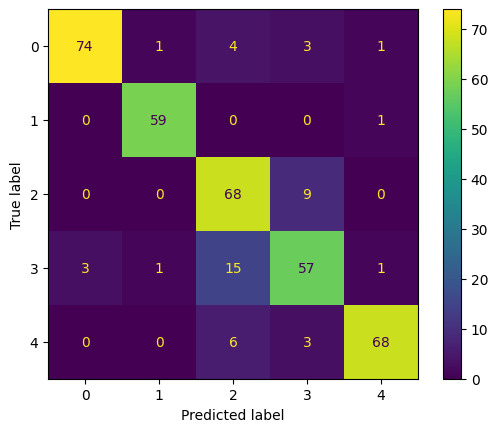

In [23]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(tmp[tmp['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=16, preprocess=preprocess_input)
    valid_gen = DataGenerator(tmp[tmp['Fold'] == i], shuffle=False, batch_size=32, preprocess=preprocess_input)
    
    print(f'### train size {len(tmp[tmp["Fold"] != i])}, valid size {len(tmp[tmp["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = opacity_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'ResNet_f{i}_c1.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid F1'].append(history.history['val_f1'])
        all_history['Train F1'].append(history.history['f1'])
        all_history['Valid Accuracy'].append(history.history['val_accuracy'])
        all_history['Train Accuracy'].append(history.history['accuracy'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}_c1.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(tmp[tmp['Fold'] == i][TARGET2].values)
    all_index.append(tmp[tmp['Fold'] == i]['Image Index'].values)
    
    plt.style.use('default')
    cm = confusion_matrix(np.argmax(tmp[tmp['Fold'] == i][TARGET2].values, axis=1), np.argmax(oof, axis=1), labels=[x for x in range(len(TARGET2))])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(len(TARGET2))])  
    disp.plot()
    plt.show()
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

**Lung Opacity Model Metric**

In [24]:
# Accuracy
accuracy = accuracy_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1))
print('Accuracy for Train Set =', accuracy)

# F1 Score
macro_f1 = f1_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1) , average='macro')
print('F1 Score for Train Set =', macro_f1)

Accuracy for Train Set = 0.8716577540106952
F1 Score for Train Set = 0.8768452403260213


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>7. Train Pleural Model</b></div>

In [25]:
tmp = df_train[df_train['Finding Labels'].isin(['Pneumothorax','Effusion'])]
tmp = tmp.reset_index(drop=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(tmp, tmp['Finding Labels'])):
    tmp.loc[valid_index, 'Fold'] = i

#########################
### Fold 1
### train size 664, valid size 167
#########################
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 65s 739ms/step - accuracy: 0.5607 - f1: 0.5308 - loss: 0.9909 - val_accuracy: 0.5119 - val_f1: 0.3461 - val_loss: 3.1158 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 501ms/step - accuracy: 0.6334 - f1: 0.5728 - loss: 0.6550 - val_accuracy: 0.5595 - val_f1: 0.4786 - val_loss: 1.9826 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 505ms/step - accuracy: 0.6920 - f1: 0.6834 - loss: 0.6279 - val_accuracy: 0.6548 - val_f1: 0.6354 - val_loss: 0.8817 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.6760 - f1: 0.6401 - loss: 0.6196
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 512ms/step - accuracy: 0.6768 - f1: 0.6414 - loss: 0.6188 - val_accuracy: 0.6905 - val_f1: 0.6000 - val_loss: 0.7440 - learning_rate: 0.0010
Epoch

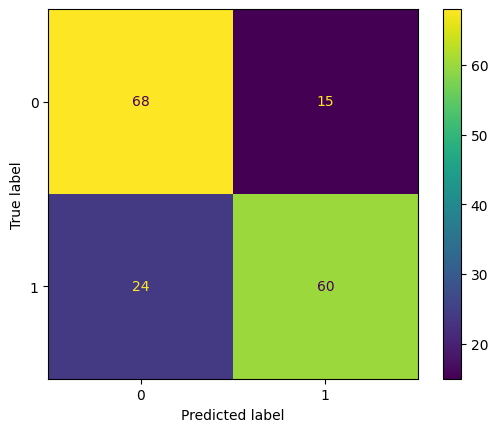

In [26]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(tmp[tmp['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=16, preprocess=preprocess_input)
    valid_gen = DataGenerator(tmp[tmp['Fold'] == i], shuffle=False, batch_size=32, preprocess=preprocess_input)
    
    print(f'### train size {len(tmp[tmp["Fold"] != i])}, valid size {len(tmp[tmp["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = pleural_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'ResNet_f{i}_c2.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid F1'].append(history.history['val_f1'])
        all_history['Train F1'].append(history.history['f1'])
        all_history['Valid Accuracy'].append(history.history['val_accuracy'])
        all_history['Train Accuracy'].append(history.history['accuracy'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}_c2.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(tmp[tmp['Fold'] == i][TARGET3].values)
    all_index.append(tmp[tmp['Fold'] == i]['Image Index'].values)
    
    plt.style.use('default')
    cm = confusion_matrix(np.argmax(tmp[tmp['Fold'] == i][TARGET3].values, axis=1), np.argmax(oof, axis=1), labels=[x for x in range(len(TARGET3))])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(len(TARGET3))])  
    disp.plot()
    plt.show()
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

**Pleural Model Metric**

In [27]:
# Accuracy
accuracy = accuracy_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1))
print('Accuracy for Train Set =', accuracy)

# F1 Score
macro_f1 = f1_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1) , average='macro')
print('F1 Score for Train Set =', macro_f1)

Accuracy for Train Set = 0.7664670658682635
F1 Score for Train Set = 0.7659299191374664


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>8. Train Parent Model</b></div>

In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

#########################
### Fold 1
### train size 2811, valid size 703
#########################
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 191s 886ms/step - accuracy: 0.4789 - f1: 0.2614 - loss: 1.5529 - val_accuracy: 0.5710 - val_f1: 0.2966 - val_loss: 1.2024 - learning_rate: 0.0010
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.5567 - f1: 0.3017 - loss: 1.1345
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
176/176 ━━━━━━━━━━━━━━━━━━━━ 147s 807ms/step - accuracy: 0.5569 - f1: 0.3018 - loss: 1.1343 - val_accuracy: 0.5256 - val_f1: 0.2629 - val_loss: 1.2810 - learning_rate: 0.0010
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 146s 807ms/step - accuracy: 0.5879 - f1: 0.3404 - loss: 1.0555 - val_accuracy: 0.6080 - val_f1: 0.3427 - val_loss: 1.0181 - learning_rate: 1.0000e-04
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.6481 - f1: 0.4021 - loss: 0.9600
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514

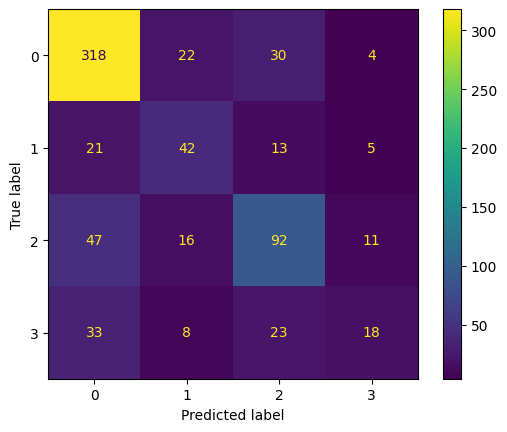

In [29]:
import tensorflow.keras.backend as K

all_oof = []
all_hierarchy_oof = []
all_true = []
all_hierarchy_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=16, preprocess=preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=32, preprocess=preprocess_input)
    
    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = parent_model()
        model2 = opacity_model()
        model3 = pleural_model()
    if LOAD_MODELS_FROM is None:
        model2.load_weights(f'ResNet_f{i}_c1.weights.h5')
        model3.load_weights(f'ResNet_f{i}_c2.weights.h5')
        
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'ResNet_f{i}_p.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid F1'].append(history.history['val_f1'])
        all_history['Train F1'].append(history.history['f1'])
        all_history['Valid Accuracy'].append(history.history['val_accuracy'])
        all_history['Train Accuracy'].append(history.history['accuracy'])

    else:
        model2.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}_c1.weights.h5')
        model3.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}_c2.weights.h5')
        
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}_p.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    opacity_predictions = model2.predict(valid_gen, verbose=1)
    pleural_predictions = model3.predict(valid_gen, verbose=1)
    
    ## hierarchy
    hierarchy_output = np.zeros((oof.shape[0], len(TARGET4)))  # Assuming 9 child classes

    for j in range(oof.shape[0]):
        if (np.argmax(oof[j]) == 0):  # Lung Opacity (index 0)
            hierarchy_output[j, :5] = oof[j, 0] * opacity_predictions[j, :]
            hierarchy_output[j, 5] = oof[j, 1]
            hierarchy_output[j,6:8] = oof[j, 2] * 0.5
            hierarchy_output[j,8] = oof[j,3]
        elif (np.argmax(oof[j]) == 2): # Pleural (index 0)
            hierarchy_output[j,:5] = oof[j, 0] * 0.2
            hierarchy_output[j, 5] = oof[j,1]
            hierarchy_output[j, 6:8] = oof[j, 2] * pleural_predictions[j,:]
            hierarchy_output[j, 8] = oof[j,3]
        else:
            hierarchy_output[j, :5] = oof[j, 0] * 0.2
            hierarchy_output[j, 5] = oof[j, 1]
            hierarchy_output[j, 6:8] = oof[j,2] * 0.5
            hierarchy_output[j, 8] = oof[j,3]
       
    all_hierarchy_oof.append(hierarchy_output)
    all_hierarchy_true.append(df_train[df_train['Fold'] == i][TARGET4].values)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_index.append(df_train[df_train['Fold'] == i]['Image Index'].values)
    
    plt.style.use('default')
    cm = confusion_matrix(np.argmax(df_train[df_train['Fold'] == i][TARGET].values, axis=1), np.argmax(oof, axis=1), labels=[x for x in range(len(TARGET))])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(len(TARGET))])  
    disp.plot()
    plt.show()
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_hierarchy_oof = np.concatenate(all_hierarchy_oof)
all_true = np.concatenate(all_true)
all_hierarchy_true = np.concatenate(all_hierarchy_true)
all_index = np.concatenate(all_index)

**Parent Model Metric**

In [30]:
# Accuracy
accuracy = accuracy_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1))
print('Accuracy for Train Set =', accuracy)

# F1 Score
macro_f1 = f1_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1) , average='macro')
print('F1 Score for Train Set =', macro_f1)

Accuracy for Train Set = 0.6685633001422475
F1 Score for Train Set = 0.5417400772907287


**Hierachy Model Metric**

In [31]:
# Accuracy
accuracy = accuracy_score(np.argmax(all_hierarchy_true, axis=1), np.argmax(all_hierarchy_oof, axis=1))
print('Accuracy for Train Set =', accuracy)

# F1 Score
f1 = f1_score(np.argmax(all_hierarchy_true, axis=1), np.argmax(all_hierarchy_oof, axis=1) , average='macro')
print('F1 Score for Train Set =', f1)

Accuracy for Train Set = 0.6216216216216216
F1 Score for Train Set = 0.6282436968299406


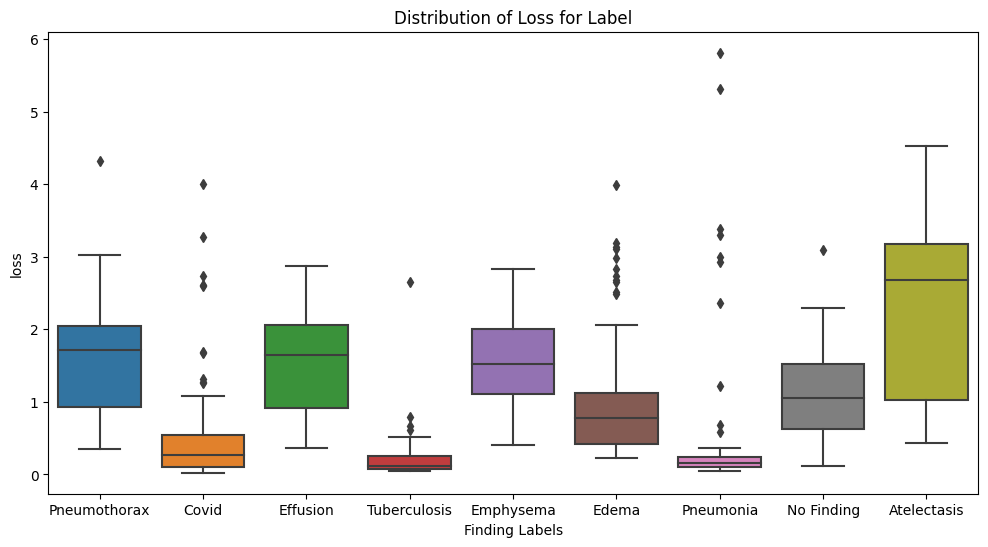

In [32]:
cce = tf.keras.losses.categorical_crossentropy(all_hierarchy_true, all_hierarchy_oof)

all_index = pd.DataFrame(all_index, columns=['Image Index'])
df_loss = pd.DataFrame(cce.numpy(), columns=['loss'])
df_loss = pd.concat([df_loss,all_index], axis=1)
df_loss = df_loss.merge(df_train, how='left', on='Image Index')

plt.figure(figsize=(12,6))

plt.title('Distribution of Loss for Label')
sns.boxplot(x='Finding Labels', y='loss', data=df_loss)
plt.show()

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>8. Inference</b></div>

Fold 1


I0000 00:00:1725436020.184102      68 service.cc:145] XLA service 0x57cac789cd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725436020.184153      68 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725436020.184159      68 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1:05 5s/step

I0000 00:00:1725436021.544399      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
Accuracy for Test Set = 0.5984072810011376
F1 Score for Test Set = 0.5849307870294298


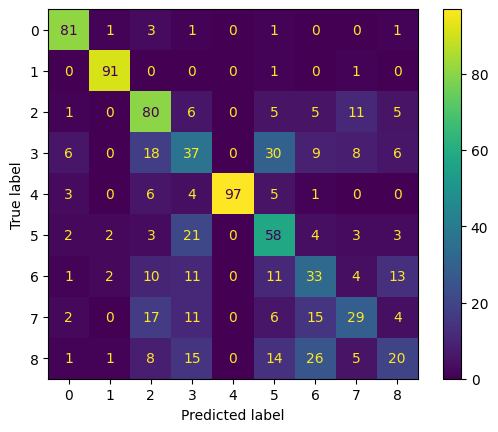

In [33]:
preds = []
model = parent_model()
model2 = opacity_model()
model3 = pleural_model()

## No TTA
test_gen = DataGenerator(df_test,shuffle=False, batch_size=64, preprocess=preprocess_input)

for i in range(1):
    print(f'Fold {i+1}') 
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}_p.weights.h5')
        model2.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}_c1.weights.h5')
        model3.load_weights((f'{LOAD_MODELS_FROM}ResNet_f{i}_c2.weights.h5'))
    else: 
        model.load_weights(f'ResNet_f{i}_p.weights.h5')
        model2.load_weights(f'ResNet_f{i}_c1.weights.h5')
        model3.load_weights((f'ResNet_f{i}_c2.weights.h5'))
    
    oof = model.predict(test_gen, verbose=1) 
    opacity_predictions = model2.predict(test_gen, verbose=1)
    pleural_predictions = model3.predict(test_gen, verbose=1)
    
    pred = np.zeros((df_test.shape[0], len(TARGET4)))  # Assuming 9 child classes
    
    for j in range(oof.shape[0]):
        if (np.argmax(oof[j]) == 0):  # Lung Opacity (index 0)
            pred[j, :5] = oof[j, 0] * opacity_predictions[j, :]
            pred[j, 5] = oof[j, 1]
            pred[j,6:8] = oof[j, 2] * 0.5
            pred[j,8] = oof[j,3]
        elif (np.argmax(oof[j]) == 2):
            pred[j,:5] = oof[j, 0] * 0.2
            pred[j, 5] = oof[j,1]
            pred[j, 6:8] = oof[j, 2] * pleural_predictions[j,:]
            pred[j, 8] = oof[j,3]
        else:
            pred[j, :5] = oof[j, 0] * 0.2
            pred[j, 5] = oof[j, 1]
            pred[j, 6:8] = oof[j,2] * 0.5
            pred[j, 8] = oof[j,3]

    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    
# Accuracy 
accuracy = accuracy_score(np.argmax(df_test[TARGET4].values, axis=1), np.argmax(pred_res, axis=1))
print('Accuracy for Test Set =', accuracy)

# F1 Score 
f1 = f1_score(np.argmax(df_test[TARGET4].values, axis=1), np.argmax(pred_res, axis=1), average='macro') 
print('F1 Score for Test Set =', f1)

cm = confusion_matrix(np.argmax(df_test[TARGET4].values, axis=1), np.argmax(pred_res, axis=1), labels=[x for x in range(len(TARGET4))])
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(len(TARGET4))])
display.plot()
plt.show()

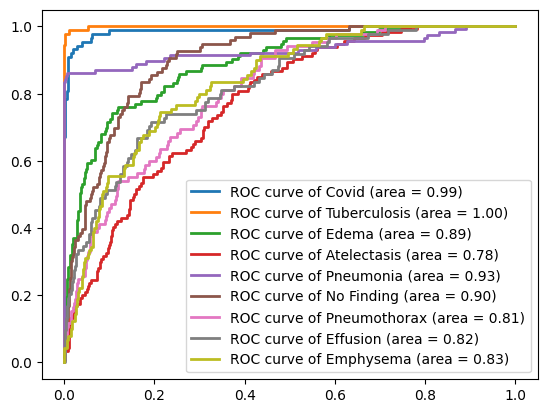

In [34]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET4)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET4[i]], pred_res[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET4)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET4[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()